In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from os import path
from astropy.io import fits

from spectrum import Spectrum
from atomic_lines import AtomicLine, NA_I_LINES, K_I_LINES, CA_I_LINES
from common import list_files, list_directories, DATA_FOLDER, tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_2723/482201296.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(15,3))


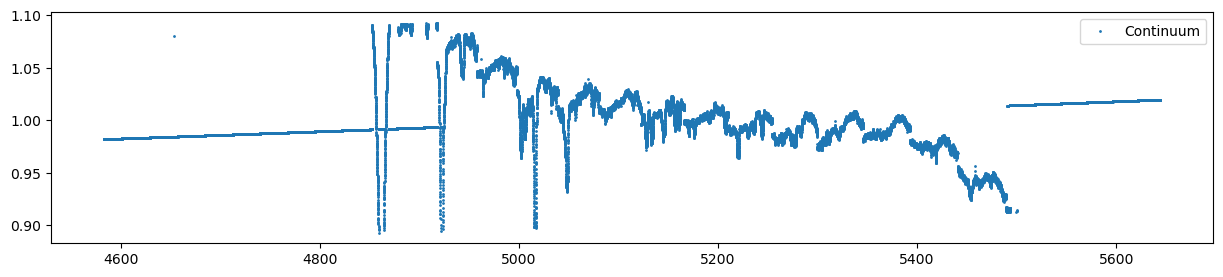

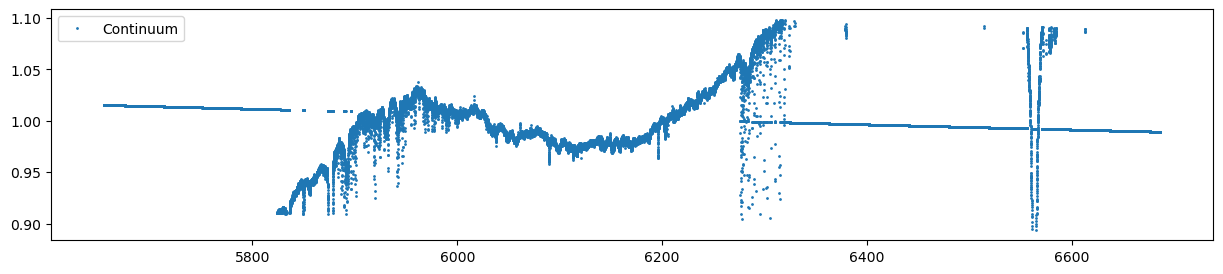

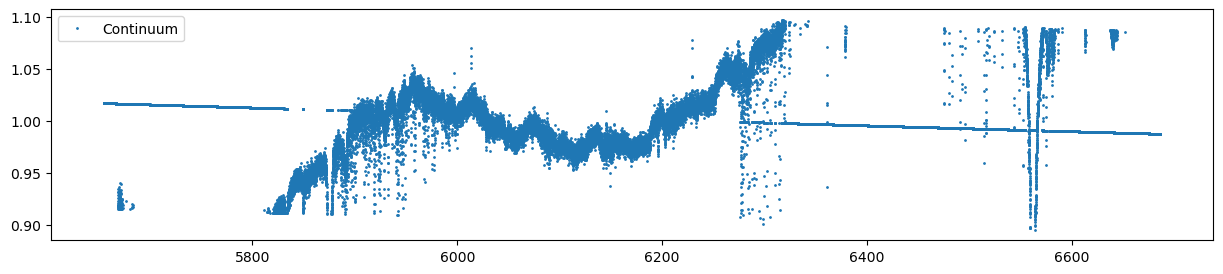

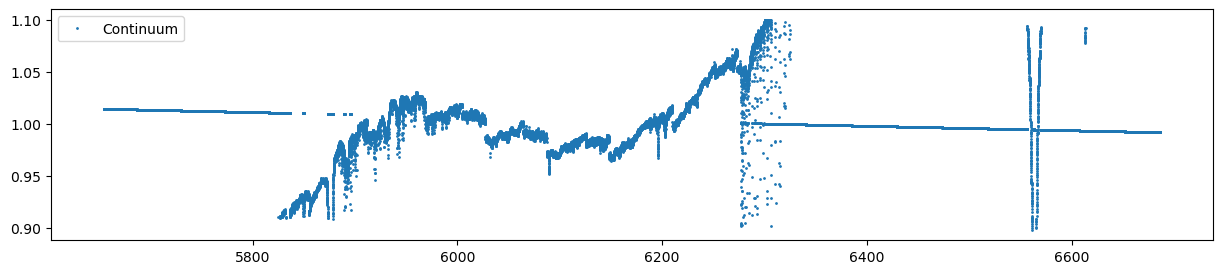

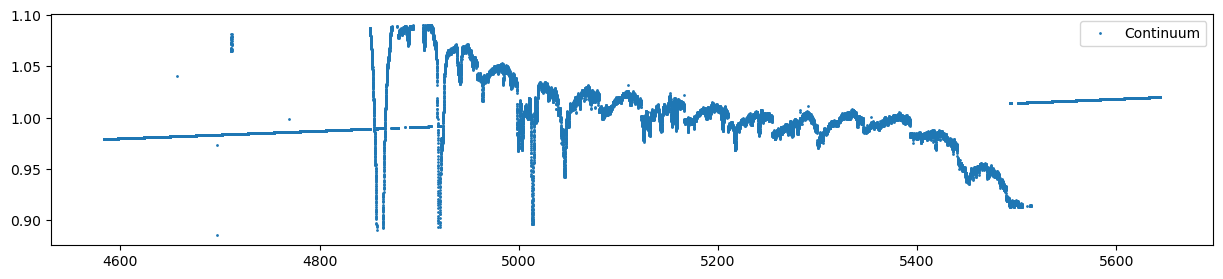

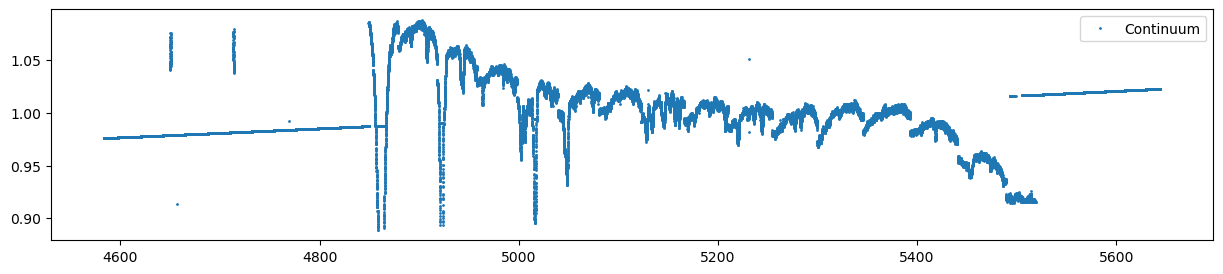

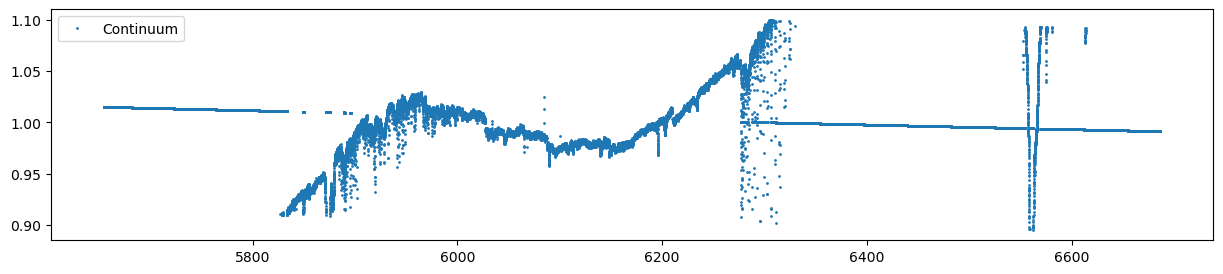

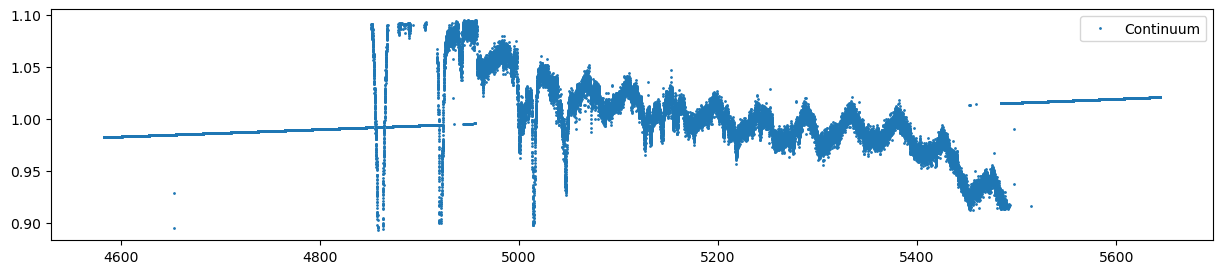

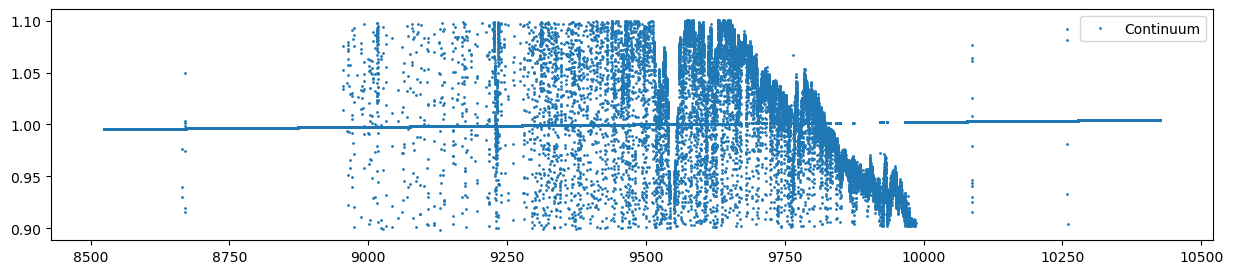

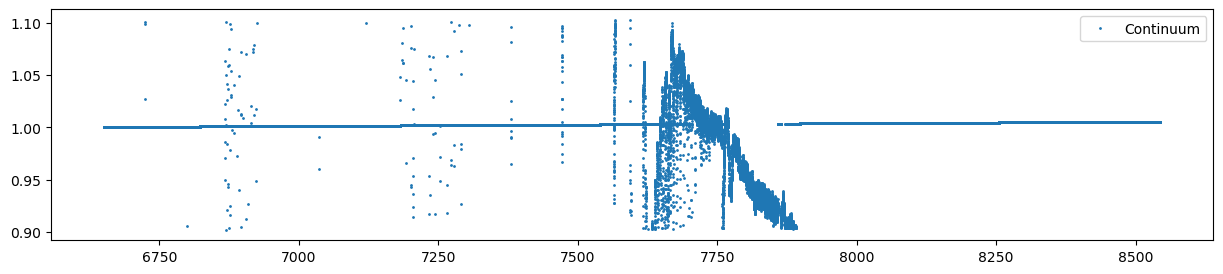

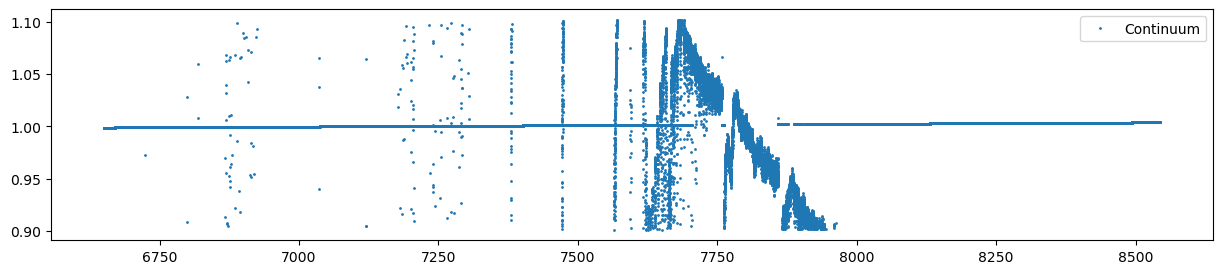

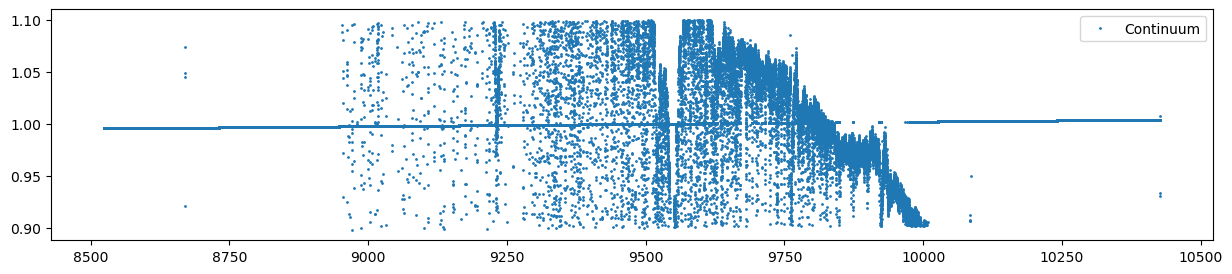

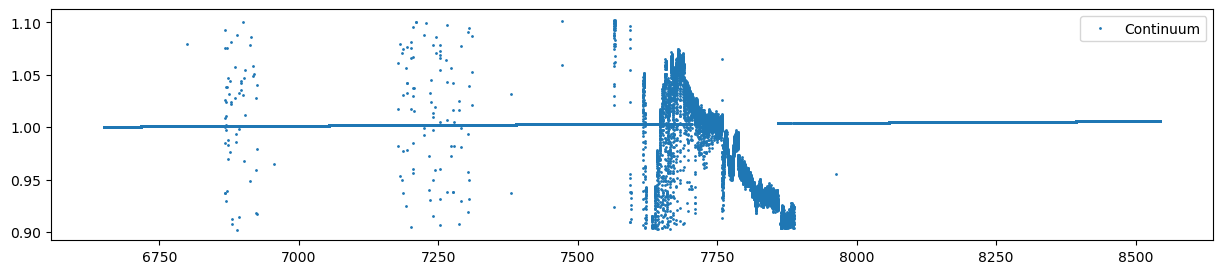

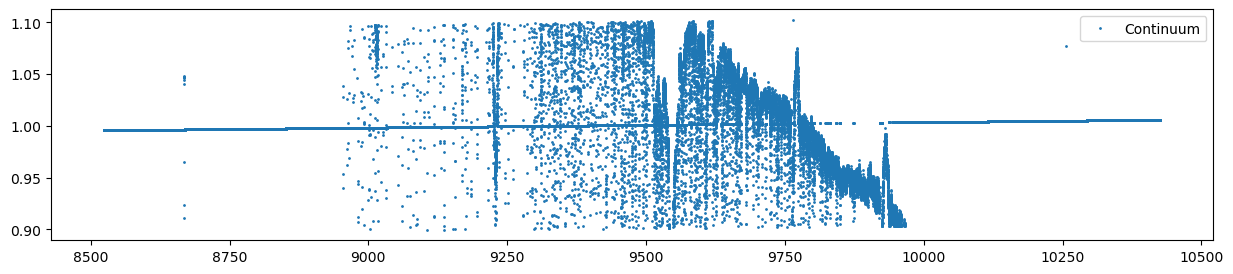

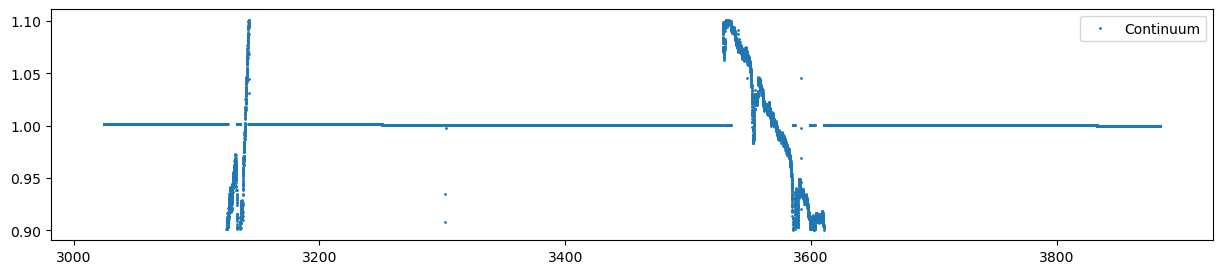

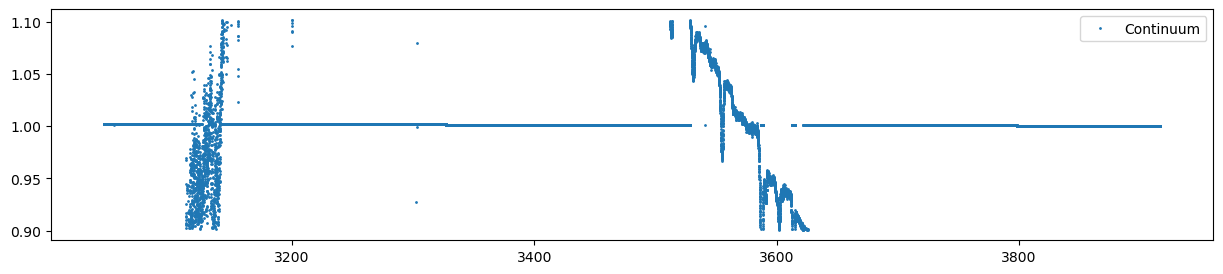

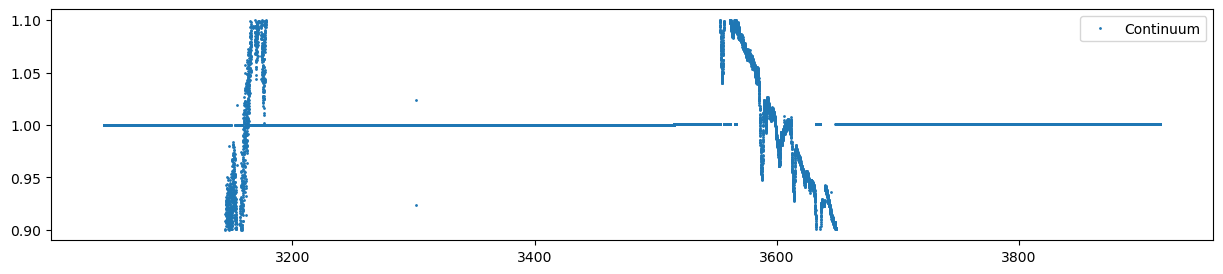

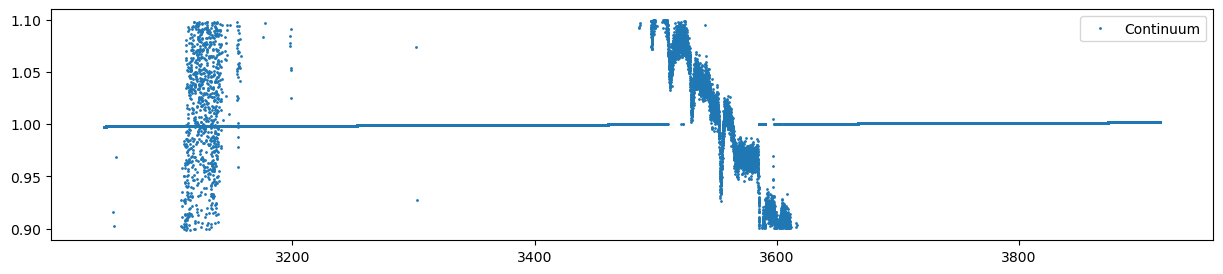

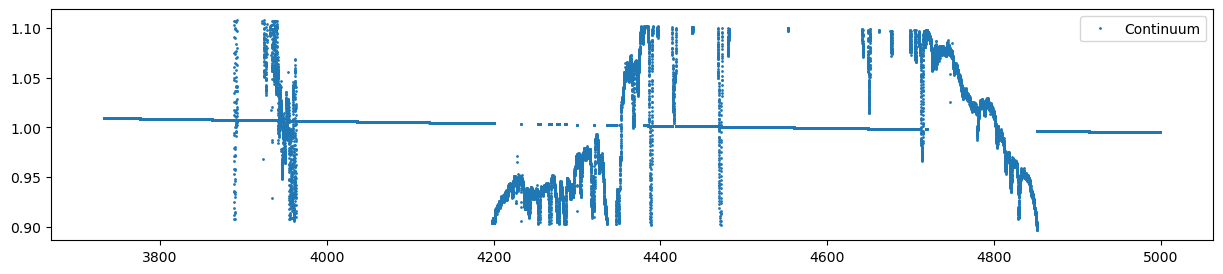

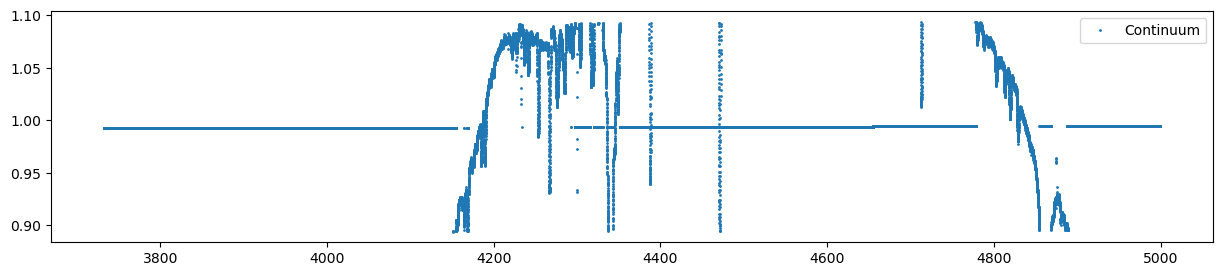

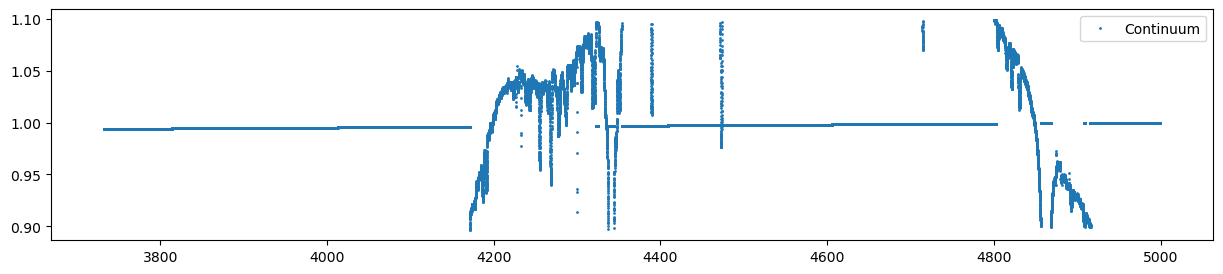

In [ ]:
def load_spectrum(datafile: str):
    wvl, flux = np.loadtxt(datafile, usecols=(0, 3), unpack=True, skiprows=1)
    target_name = path.basename(datafile).split('_')[0]

    return Spectrum(target_name, wvl, flux)

def load_fits_to_spectrum(target_dir: str):
    sub_spectra = []
    
    for band_dir in list_directories(target_dir):
        for datafile in list_files(band_dir):
            if not datafile.endswith('.fits'):
                print(f'[WARNING]: skipping unexpected datafile: {datafile}')
                continue

            with fits.open(datafile) as hdulist:
                header = hdulist[0].header
                target = header['OBJECT']
                starting_wvl = header['CRVAL1']
                stepsize_wvl = header['CDELT1']

                flux = hdulist[0].data
                wavelength = np.arange(0, len(flux), 1) * stepsize_wvl + starting_wvl
                flux[np.abs(flux) > 1.01 * np.median(flux)] = np.median(flux)

                fig, ax = plt.subplots(1, 1, figsize=(15,3))
                spectrum = Spectrum(target, wavelength, flux).normalize(1, ax)
                sub_spectra.append(spectrum)

    return sub_spectra

hd23180 = load_fits_to_spectrum('data/fits/HD23180')
# spectra = [load_fits_to_spectrum(target_dir) for target_dir in tqdm(list_directories(path.join(DATA_FOLDER, 'fits')), 'Loading spectra')]

# hd23180 = load_spectrum('data/DR4/HD23180_w564_n3_20140923_U.ascii')
# spectra = [load_spectrum(datafile) for datafile in tqdm(list_files(path.join(DATA_FOLDER, 'DR4')), 'Loading spectra')]

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
na_line_pairs = hd23180.identify_atomic_line(
    NA_I_LINES[0], NA_I_LINES[1],
    axes=axes, draw_expected=True,
    output_difference=True,
    output_radial_velocity=True
)

fig.suptitle(f'Na I atomic line detection for {hd23180.target}')
fig.tight_layout()

tabulate(na_line_pairs, ['Line 1 [Å]', 'Line 2 [Å]', 'Deviation [Å]', 'Radial velocity [km/s]'], tablefmt='html')

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
k_line_pairs = hd23180.identify_atomic_line(
    K_I_LINES[2], K_I_LINES[3],
    axes=axes, draw_expected=True,
    output_difference=True,
    output_radial_velocity=True
)

fig.suptitle(f'K I atomic line detection for {hd23180.target}')
fig.tight_layout()

tabulate(k_line_pairs, ['Line 1 [Å]', 'Line 2 [Å]', 'Deviation [Å]', 'Radial velocity [km/s]'], tablefmt='html')

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
ca_line_pairs = hd23180.identify_atomic_line(
    CA_I_LINES[0], CA_I_LINES[1],
    axes=axes, draw_expected=True,
    output_difference=True,
    output_radial_velocity=True
)

fig.suptitle(f'Ca I atomic line detection for {hd23180.target}')
fig.tight_layout()

tabulate(ca_line_pairs, ['Line 1 [Å]', 'Line 2 [Å]', 'Deviation [Å]', 'Radial velocity [km/s]'], tablefmt='html')

In [ ]:
def create_line_pair_table_rows(spectrum: Spectrum, line1: AtomicLine, line2: AtomicLine):
    line_pairs = spectrum.identify_atomic_line(line1, line2, output_difference=True, output_radial_velocity=True, tollerance=None)
    extra_info = [spectrum.target]
    return np.column_stack((np.full((line_pairs.shape[0], len(extra_info)), extra_info), line_pairs))

In [ ]:
na_line_pairs_all = np.concatenate([create_line_pair_table_rows(spectrum, NA_I_LINES[0], NA_I_LINES[1]) for spectrum in tqdm(spectra, 'Searching Na I lines')])

headers = ['Target', 'Line 1 [Å]', 'Line 2 [Å]', 'Deviation [Å]', 'Radial velocity [km/s]']
tabulate(na_line_pairs_all, headers, tablefmt='html')

In [ ]:
k_line_pairs_all = np.concatenate([create_line_pair_table_rows(spectrum, K_I_LINES[2], K_I_LINES[3]) for spectrum in tqdm(spectra, 'Searching K I lines')])

headers = ['Target', 'Line 1 [Å]', 'Line 2 [Å]', 'Deviation [Å]', 'Radial velocity [km/s]']
tabulate(k_line_pairs_all, headers, tablefmt='html')

In [ ]:
ca_line_pairs_all = np.concatenate([create_line_pair_table_rows(spectrum, CA_I_LINES[0], CA_I_LINES[1]) for spectrum in tqdm(spectra, 'Searching Ca I lines')])

headers = ['Target', 'Line 1 [Å]', 'Line 2 [Å]', 'Deviation [Å]', 'Radial velocity [km/s]']
tabulate(ca_line_pairs_all, headers, tablefmt='html')

In [ ]:
len(np.unique([spectrum.target for spectrum in spectra]))